## Description
This script illustrates how we identify factors of NfL - Figure 2 - 3

## Figure 2A - NfL increase over time

/var/folders/6r/pj2ql3m51fv8_ycglzy0hnh40000gn/T/ipykernel_67823/1195183267.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best = res_df.groupby("response").apply(lambda g: g.loc[g["AIC"].idxmin()])



=== Best curvature exponents ===
         response  power          AIC          BIC
response                                          
log_nfl   log_nfl   0.65   299.989707   311.172869
nfl           nfl   1.25  1528.021024  1539.204186

=== LOG_NFL Model (Power 0.65) ===
AIC=299.99, BIC=311.17, logLik=-145.99, MSE=0.2562, R2=0.8582
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     log_nfl  
No. Observations:     121         Method:                 ML       
No. Groups:           35          Scale:                  0.3446   
Min. group size:      1           Log-Likelihood:         -145.9949
Max. group size:      4           Converged:              Yes      
Mean group size:      3.5                                          
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------

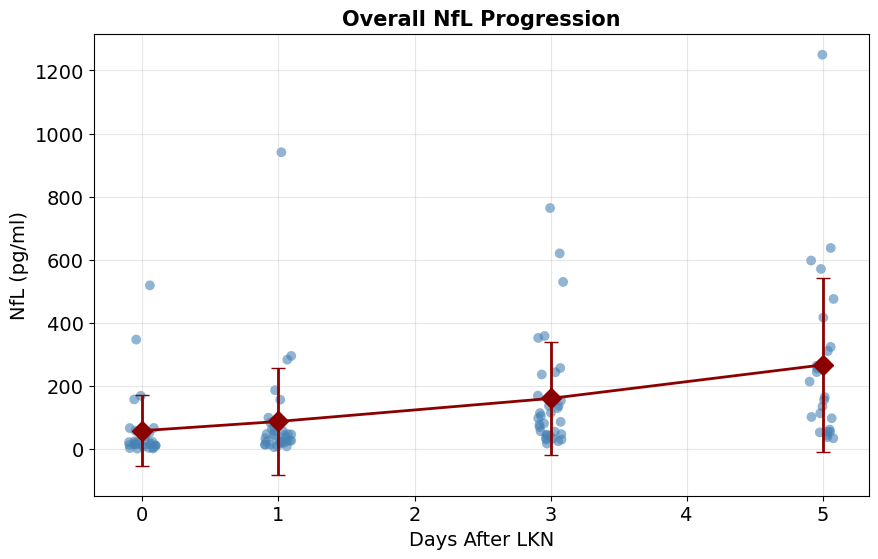

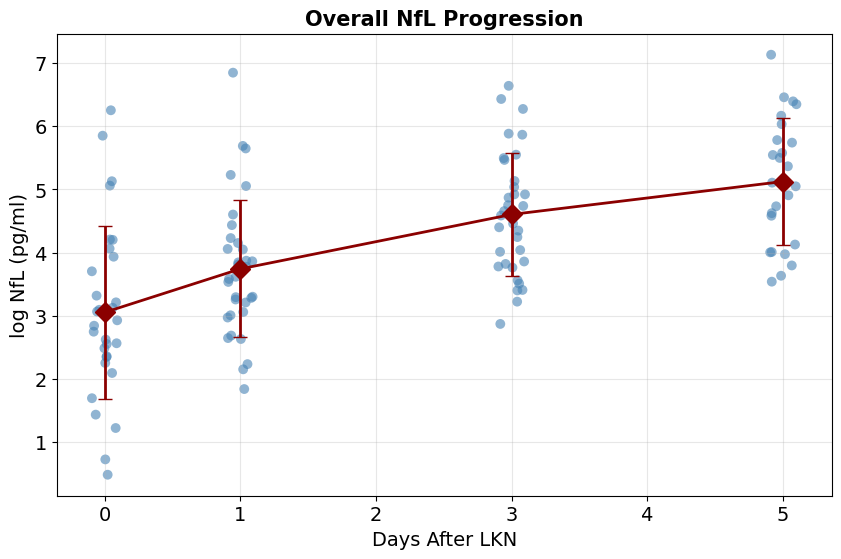

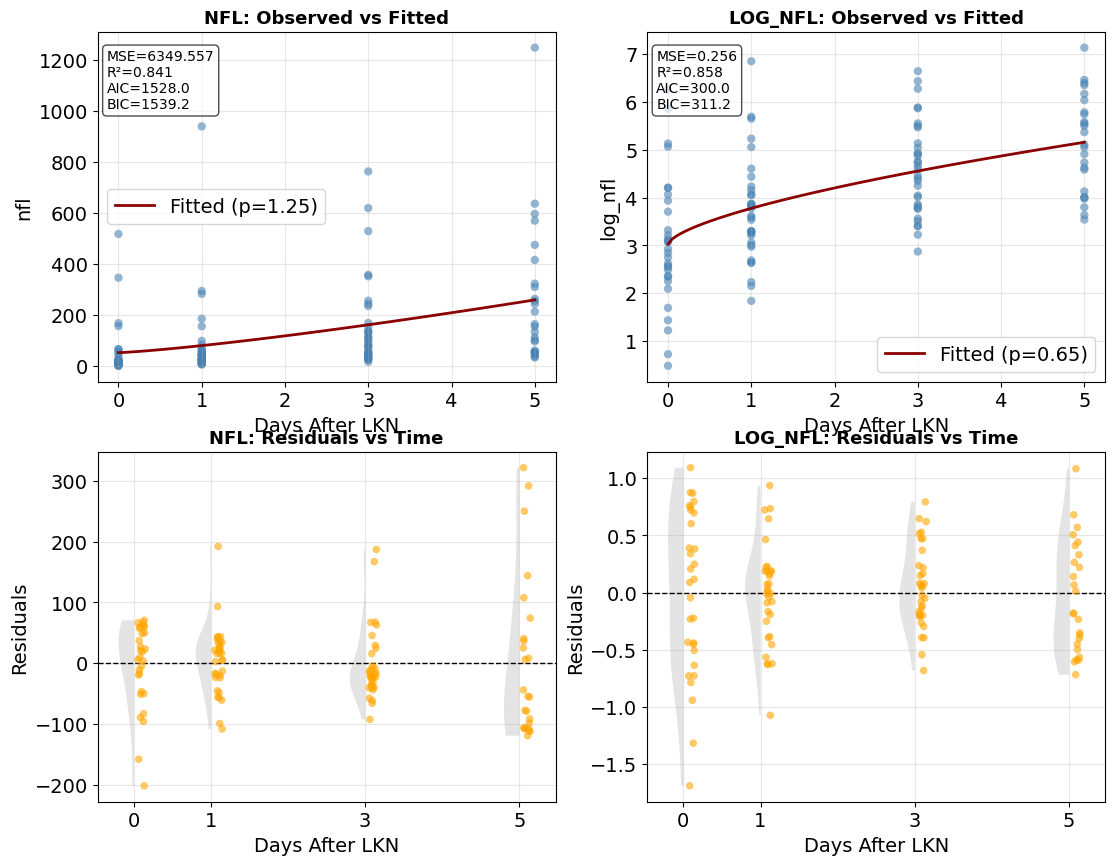

In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
nfl_df = pd.read_csv('nihss_nfl_cyto_mrs_wbc_mrs_ct.csv', 
                     index_col=0)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 14

nfl_timepoints = [0, 1, 3, 5]
nfl_plot_data = nfl_df[nfl_df['days_after_lkn'].isin(nfl_timepoints)].copy()
# Drop missing values
nfl_plot_data = nfl_plot_data[nfl_plot_data['nfl'].notna()].copy()
nfl_plot_data = nfl_plot_data.drop_duplicates(subset=['personid', 'days_after_lkn', 'nfl'])
nfl_plot_data['log_nfl'] = np.log(nfl_plot_data['nfl'])
def get_summary(df, yvar):
    return df.groupby('days_after_lkn')[yvar].agg(['mean', 'std', 'count']).reset_index()

# --- 5. Plot ---
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x_order = [0, 1, 3, 5]
jitter_strength = 0.1  # adjust (e.g., ±0.1 days)
x_jittered = nfl_plot_data["days_after_lkn"] + np.random.uniform(
    -jitter_strength, jitter_strength, size=len(nfl_plot_data)
)

# Scatter with jitter

ax.scatter(
    x_jittered,
    nfl_plot_data["nfl"],
    alpha=0.6,
    s=50,
    color="steelblue",
    edgecolor="none"
)
stats = get_summary(nfl_plot_data, 'nfl')
ax.errorbar(stats['days_after_lkn'], stats['mean'], yerr=stats['std'],
            fmt='D-', color='darkred', linewidth=2, markersize=10, capsize=5)
ax.set_title('Overall NfL Progression', fontsize=15, fontweight='bold')
ax.set_xlabel('Days After LKN')
ax.set_ylabel('NfL (pg/ml)')
ax.grid(True, alpha=0.3)


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x_order = [0, 1, 3, 5]
jitter_strength = 0.1  # adjust (e.g., ±0.1 days)
x_jittered = nfl_plot_data["days_after_lkn"] + np.random.uniform(
    -jitter_strength, jitter_strength, size=len(nfl_plot_data)
)


ax.scatter(
    x_jittered,
    nfl_plot_data["log_nfl"],
    alpha=0.6,
    s=50,
    color="steelblue",
    edgecolor="none"
)
stats = get_summary(nfl_plot_data, 'log_nfl')
ax.errorbar(stats['days_after_lkn'], stats['mean'], yerr=stats['std'],
            fmt='D-', color='darkred', linewidth=2, markersize=10, capsize=5)
ax.set_title('Overall NfL Progression', fontsize=15, fontweight='bold')
ax.set_xlabel('Days After LKN')
ax.set_ylabel('log NfL (pg/ml)')
ax.grid(True, alpha=0.3)

nfl_timepoints = [0, 1, 3, 5]
nfl_plot_data = nfl_df[nfl_df['days_after_lkn'].isin(nfl_timepoints)].copy()
# Drop missing values
nfl_plot_data = nfl_plot_data[nfl_plot_data['nfl'].notna()].copy()
nfl_plot_data = nfl_plot_data.drop_duplicates(subset=['personid', 'days_after_lkn', 'nfl'])
nfl_plot_data['log_nfl'] = np.log(nfl_plot_data['nfl'])
# check if linear or nonlinear fit the data better
powers = np.linspace(0.3, 1.8, 31)   #
results = []

for yvar in ["nfl", "log_nfl"]:
    for p in powers:
        # transform time
        nfl_plot_data[f"time_pow_{p:.2f}"] = nfl_plot_data["days_after_lkn"] ** p

        formula = f"{yvar} ~ I(days_after_lkn ** {p})"
        try:
            model = smf.mixedlm(formula, nfl_plot_data, groups=nfl_plot_data["personid"], re_formula="1")
            result = model.fit(method="powell", reml=False, maxiter=500, disp=False)
            results.append({
                "response": yvar,
                "power": p,
                "logLik": result.llf,
                "AIC": result.aic,
                "BIC": result.bic
            })
        except Exception as e:
            results.append({"response": yvar, "power": p, "logLik": np.nan, "AIC": np.nan, "BIC": np.nan})
            print(f"Power {p:.2f} failed for {yvar}: {e}")

res_df = pd.DataFrame(results)
best = res_df.groupby("response").apply(lambda g: g.loc[g["AIC"].idxmin()])
print("\n=== Best curvature exponents ===")
print(best[["response", "power", "AIC", "BIC"]])

# show the regressed line and residual to quantify the goodness of fit


best_power = dict(zip(best["response"], best["power"]))
goodness = {}

for yvar, p in best_power.items():
    formula = f"{yvar} ~ I(days_after_lkn ** {p})"
    model = smf.mixedlm(formula, nfl_plot_data, groups=nfl_plot_data["personid"], re_formula="1")
    result = model.fit(method="powell", reml=False, disp=False)

    # Predictions & residuals
    nfl_plot_data[f"{yvar}_pred"] = result.fittedvalues
    nfl_plot_data[f"{yvar}_resid"] = nfl_plot_data[yvar] - result.fittedvalues

    # Metrics
    mse = mean_squared_error(nfl_plot_data[yvar], nfl_plot_data[f"{yvar}_pred"])
    r2 = r2_score(nfl_plot_data[yvar], nfl_plot_data[f"{yvar}_pred"])
    aic, bic, llf = result.aic, result.bic, result.llf

    goodness[yvar] = dict(power=p, MSE=mse, R2=r2, AIC=aic, BIC=bic, logLik=llf,
                          Intercept=result.fe_params['Intercept'],
                          Slope=result.fe_params[f'I(days_after_lkn ** {p})'])

    print(f"\n=== {yvar.upper()} Model (Power {p:.2f}) ===")
    print(f"AIC={aic:.2f}, BIC={bic:.2f}, logLik={llf:.2f}, MSE={mse:.4f}, R2={r2:.4f}")
    print(result.summary())

goodness_df = pd.DataFrame(goodness).T
print("\n=== Goodness of Fit Summary ===")
print(goodness_df.round(4))
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

for i, yvar in enumerate(["nfl", "log_nfl"]):
    p = best_power[yvar]

    # --- (A,B) Observed vs fitted line ---
    ax = axes[0, i]
    sns.scatterplot(
        data=nfl_plot_data, x="days_after_lkn", y=yvar,
        alpha=0.6, color="steelblue", edgecolor="none", ax=ax
    )

    t_seq = np.linspace(nfl_plot_data["days_after_lkn"].min(), nfl_plot_data["days_after_lkn"].max(), 100)
    y_pred_line = (
        goodness[yvar]["Intercept"] +
        goodness[yvar]["Slope"] * (t_seq ** p)
    )
    ax.plot(t_seq, y_pred_line, color="darkred", linewidth=2, label=f"Fitted (p={p:.2f})")
    ax.text(
        0.02, 0.95,
        f"MSE={goodness[yvar]['MSE']:.3f}\nR²={goodness[yvar]['R2']:.3f}\n"
        f"AIC={goodness[yvar]['AIC']:.1f}\nBIC={goodness[yvar]['BIC']:.1f}",
        transform=ax.transAxes, fontsize=10, va="top", ha="left",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )
    ax.set_title(f"{yvar.upper()}: Observed vs Fitted", fontsize=13, fontweight="bold")
    ax.set_xlabel("Days After LKN")
    ax.set_ylabel(yvar)
    ax.legend()
    ax.grid(alpha=0.3)

    # --- (C,D) Residuals: half violin (left) + stripplot (right) ---
    axr = axes[1, i]

    # Ensure numeric
    # df["days_after_lkn"] = pd.to_numeric(df["days_after_lkn"], errors="coerce")
    
    x_positions = sorted(nfl_plot_data["days_after_lkn"].dropna().unique())
    
    for x in x_positions:
        subset = nfl_plot_data.loc[nfl_plot_data["days_after_lkn"] == x, f"{yvar}_resid"].dropna()
        if len(subset) == 0:
            continue
    
        # Left half violin
        vp = axr.violinplot(subset, positions=[x], widths=0.4,
                            showmeans=False, showextrema=False)
        for pc in vp['bodies']:
            m = np.mean(pc.get_paths()[0].vertices[:, 0])
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
            pc.set_facecolor("lightgray")
            pc.set_edgecolor("none")
            pc.set_alpha(0.6)
    
    # Right half: stripplot slightly offset to the right
    x_jittered = (
        nfl_plot_data["days_after_lkn"]
        + np.random.uniform(0.05, 0.15, size=len(nfl_plot_data))  # small right offset
    )
    axr.scatter(
        x_jittered,
        nfl_plot_data[f"{yvar}_resid"],
        color="orange", alpha=0.6, s=30, edgecolors="none", zorder=10
    )
    
    axr.axhline(0, color="black", linestyle="--", linewidth=1)
    axr.set_xticks(x_positions)
    axr.set_xticklabels(x_positions)
    axr.set_title(f"{yvar.upper()}: Residuals vs Time", fontsize=13, fontweight="bold")
    axr.set_xlabel("Days After LKN")
    axr.set_ylabel("Residuals")
    axr.grid(alpha=0.3)
    



# # preprocessing for smoking
# # so 1 means either former or current smoker
# nfl_plot_data['smoking_binary'] = nfl_plot_data['smoking'].map({0: 0, 1: 1, 2: 1})
# # so tici_binary == 1 means good reperfusion
# nfl_plot_data['tici_binary'] = nfl_plot_data['tici'].map({'0': 0, '1':1,  '2A': 0, '2B': 0, '2C':1, '3':1})

# # testing
# # for var_name, mapping, levels, palette in [
# #     ("smoking_binary", smoking_binary_mapping, smoking_binary_levels, smoking_binary_palette),

# # ]:
# #     for yvar in ["nfl", "log_nfl"]:
# #         key = f"{yvar}_{var_name}"
# #         comp_df, best_power, res, result_row, eff_tbl = compare_categorical_models(
# #             nfl_plot_data, yvar, best_power_base, 
# #             var_name, levels, mapping, fig_dir, palette
# #         )


## Function to identify categorical factors

In [15]:
def compare_categorical_models(nfl_plot_data, yvar, best_power_base, 
                                col_name, col_levels, col_mapping, fig_dir,
                                col_palette=None):
    """
    function to compare models with categorical variables (sex, race, etc.)
    
    Parameters:
    -----------
    nfl_plot_data : DataFrame
        The dataset
    yvar : str
        Response variable name (e.g., 'nfl', 'log_nfl')
    best_power_base : dict
        Dictionary of best power transformations from base models
    col_name : str
        Name of the categorical column (e.g., 'sex', 'race')
    col_levels : list
        Ordered list of category levels (e.g., ['Male', 'Female'])
    col_mapping : dict
        Mapping from numeric to text labels (e.g., {0: 'Male', 1: 'Female'})
    col_palette : dict, optional
        Color palette for plotting (e.g., {'Male': '#1f77b4', 'Female': '#d62728'})
    
    Returns:
    --------
    comp_df : DataFrame
        Model comparison results
    best_power : float
        Best power transformation
    final_res : fitted model
        Final model results
    result_row : dict
        Summary statistics
    eff_tbl : DataFrame
        Effect size table
    """
    
    #  text column
    col_text = f"{col_name}_text"
    nfl_plot_data[col_text] = nfl_plot_data[col_name].map(col_mapping)
    
    if col_palette is None:
        col_palette = {col_levels[0]: "#1f77b4", col_levels[1]: "#d62728"}
    
    print(f"\n{'='*80}\nAnalyzing {yvar.upper()} with {col_name.upper()}...")
    print(f"Effect sizes represent: {col_levels[1]} - {col_levels[0]}")
    print('='*80)
    def _summarize(sub):
        ref, other = col_levels
        m = sub.loc[sub[col_text] == ref, yvar].dropna()
        f = sub.loc[sub[col_text] == other, yvar].dropna()
        if len(m) < 2 or len(f) < 2:
            return dict(welch_p=np.nan, mann_p=np.nan, d=np.nan, delta=np.nan)
        
        # auxilary function for evaluating the statistics
        _, p_welch = ttest_ind(m, f, equal_var=False)

        u_stat, p_mann = mannwhitneyu(m, f, alternative="two-sided")
        n1, n2 = len(m), len(f)
        sp = np.sqrt(((n1-1)*m.var(ddof=1)+(n2-1)*f.var(ddof=1))/(n1+n2-2))
        d = (m.mean() - f.mean())/sp if sp>0 else np.nan
        delta = cliff_delta(m, f)
        return dict(welch_p=p_welch, mann_p=p_mann, d=d, delta=delta)
    
    def decide_model(fig_dir, alpha=0.05, stability_thr=0.2):
        # Per-timepoint summaries
        out = []
        for tp in sorted(nfl_plot_data["days_after_lkn"].dropna().unique()):
            sub = nfl_plot_data[nfl_plot_data["days_after_lkn"]==tp]
            r = _summarize(sub)
            r["time"] = tp
            out.append(r)
        tp_df = pd.DataFrame(out)
        
        # Overall
        overall = _summarize(nfl_plot_data)
        
        any_sig = ((tp_df["mann_p"] < alpha).any() or (overall["mann_p"] < alpha))
        
        if not any_sig:
            print(f"\nNo significant {col_name} difference detected for {yvar}.")
            return dict(mode="exclude", 
                       reason=f"No significant {col_name} difference overall or by timepoint.",
                       tp_df=tp_df, overall=overall)
        
        # Detect sign flips
        dvals = tp_df["delta"].to_numpy()
        pvals = tp_df["mann_p"].to_numpy()
        signs = np.sign(dvals)
        flip_idx = np.where(np.diff(signs) != 0)[0]
        flip_is_meaningful = False
        for i in flip_idx:
            left_d, right_d = abs(dvals[i]), abs(dvals[i+1])
            left_p, right_p = pvals[i], pvals[i+1]
            if ((left_p < alpha and right_p < alpha) or
                (left_d > stability_thr and right_d > stability_thr)):
                flip_is_meaningful = True
                break
        
        if flip_is_meaningful:
            return dict(mode="exclude",
                       reason=f"{col_name} effect flips direction between strong timepoints.",
                       tp_df=tp_df, overall=overall)
        
        #  stability vs localized bump
        abs_d = np.abs(tp_df["delta"].to_numpy())
        peakiness = abs_d.max() - np.median(abs_d)
        
        times = tp_df["time"].to_numpy()
        if peakiness <= stability_thr / 2:
            mode = "linear"
            reason = f"Stable {col_name} effect (peak–median |d|={peakiness:.2f})"
            mu = sigma = None
        else:
            mu, sigma = estimate_peak_and_sigma(times, abs_d, smooth=0.3)
            mode = "gaussian"
            reason = f"Localized {col_name} effect (peak at day {mu:.2f}, σ={sigma:.2f})"
                
     
        return dict(mode=mode, reason=reason, tp_df=tp_df, overall=overall,
                   mu=mu, sigma=sigma)
    
    print("\nPer-timepoint effect table:")
    print(eff_tbl.round(3))
    eff_tbl["response"] = yvar
    eff_tbl["categorical_var"] = col_name
    
    decision = decide_model(fig_dir)
    print(f"\nDecision: {decision['mode'].upper()} | {decision['reason']}")
    
    # Build and fit models
    base_p = best_power_base[yvar]
    nfl_plot_data["time_pow"] = nfl_plot_data["days_after_lkn"] ** base_p
    base_model = smf.mixedlm(f"{yvar} ~ time_pow", nfl_plot_data,
                             groups=nfl_plot_data["personid"], re_formula="1")
    base_res = base_model.fit(method="powell", reml=False, disp=False)
    
    def build_formula(df, mode, p, mu=None, sigma=None):
        df["time_pow_tmp"] = df["days_after_lkn"] ** p
        if mode == "exclude":
            return f"{yvar} ~ time_pow_tmp"
        elif mode == "linear":
            return f"{yvar} ~ time_pow_tmp + {col_name}"
        elif mode == "gaussian":
            df[f"{col_name}_gauss"] = df[col_name] * np.exp(-((df["days_after_lkn"] - mu)**2) / (2 * sigma**2))
            return f"{yvar} ~ time_pow_tmp + {col_name}_gauss"
    
    # Power grid search
    powers = np.linspace(0.3, 1.8, 31)
    search_results = []
    for p in powers:
        try:
            formula = build_formula(nfl_plot_data, decision["mode"], p,
                                   decision.get("mu"), decision.get("sigma"))
            model_tmp = smf.mixedlm(formula, nfl_plot_data,
                                   groups=nfl_plot_data["personid"], re_formula="1")
            res_tmp = model_tmp.fit(method="powell", reml=False, disp=False)
            search_results.append({"power": p, "AIC": res_tmp.aic,
                                 "BIC": res_tmp.bic, "logLik": res_tmp.llf, "res": res_tmp})
        except Exception:
            search_results.append({"power": p, "AIC": np.nan,
                                 "BIC": np.nan, "logLik": np.nan, "res": None})
    
    search_df = pd.DataFrame(search_results)
    best_row = search_df.loc[search_df["AIC"].idxmin()]
    best_power = float(best_row["power"])
    final_res = best_row["res"]
    
    # Calculate metrics
    MSE_base = mean_squared_error(nfl_plot_data[yvar], base_res.fittedvalues)
    MSE_final = mean_squared_error(nfl_plot_data[yvar], final_res.fittedvalues) if final_res else np.nan
    R2_base = r2_score(nfl_plot_data[yvar], base_res.fittedvalues)
    R2_final = r2_score(nfl_plot_data[yvar], final_res.fittedvalues) if final_res else np.nan
    delta_AIC = base_res.aic - (final_res.aic if final_res else base_res.aic)
    delta_BIC = base_res.bic - (final_res.bic if final_res else base_res.bic)
    delta_R2 = R2_final - R2_base if not np.isnan(R2_final) else 0
    delta_MSE = MSE_base - MSE_final if not np.isnan(MSE_final) else 0
    
    # Comparison DataFrame
    comp = pd.DataFrame([
        dict(Model="Base", mode="exclude", power=base_p,
             AIC=base_res.aic, BIC=base_res.bic, logLik=base_res.llf,
             R2=R2_base, MSE=MSE_base),
        dict(Model=f"{col_name.title()}-adjusted", mode=decision["mode"], power=best_power,
             AIC=final_res.aic if final_res else np.nan,
             BIC=final_res.bic if final_res else np.nan,
             logLik=final_res.llf if final_res else np.nan,
             R2=R2_final, MSE=MSE_final)
    ])
    print(f"\n=== Model Comparison (Base vs {col_name.title()}-adjusted) ===")
    print(comp.round(4))
    
    # Extract coefficients
    coef_base = base_res.fe_params.to_dict()
    p_base = base_res.pvalues.to_dict()
    coef_final = final_res.fe_params.to_dict() if final_res else {}
    p_final = final_res.pvalues.to_dict() if final_res else {}
    
    coef_summary = {
        "Intercept_base": coef_base.get("Intercept", np.nan),
        "Intercept_base_p": p_base.get("Intercept", np.nan),
        "time_pow_base": coef_base.get("time_pow", np.nan),
        "time_pow_base_p": p_base.get("time_pow", np.nan),
        "Intercept_final": coef_final.get("Intercept", np.nan),
        "Intercept_final_p": p_final.get("Intercept", np.nan),
        "time_pow_final": coef_final.get("time_pow_tmp", np.nan),
        "time_pow_final_p": p_final.get("time_pow_tmp", np.nan),
        f"{col_name}_effect_final": coef_final.get(f"{col_name}", np.nan),
        f"{col_name}_effect_final_p": p_final.get(f"{col_name}", np.nan),
        f"{col_name}_gauss_final": coef_final.get(f"{col_name}_gauss", np.nan),
        f"{col_name}_gauss_final_p": p_final.get(f"{col_name}_gauss", np.nan)
    }
    # print(coef_final)
    # print(f"C({col_name})[T.{col_levels[1]}]")
    # f"{col_name}_effect_final": coef_final.get(f"C({col_name})[T.{col_levels[1]}]", np.nan),
    #     f"{col_name}_effect_final_p": p_final.get(f"C({col_name})[T.{col_levels[1]}]", np.nan),
    
    result_row = {
        "response": yvar,
        "categorical_var": col_name,
        "decision_mode": decision["mode"],
        "decision_reason": decision["reason"],
        "best_power_base": base_p,
        "best_power_final": best_power,
        "AIC_base": base_res.aic,
        "AIC_final": final_res.aic if final_res else np.nan,
        "BIC_base": base_res.bic,
        "BIC_final": final_res.bic if final_res else np.nan,
        "R2_base": R2_base,
        "R2_final": R2_final,
        "MSE_base": MSE_base,
        "MSE_final": MSE_final,
        "delta_AIC": delta_AIC,
        "delta_BIC": delta_BIC,
        "delta_R2": delta_R2,
        "delta_MSE": delta_MSE,
        **coef_summary
    }
    result_row.update({
        "gauss_mu": decision.get("mu", np.nan),
        "gauss_sigma": decision.get("sigma", np.nan)
    })
    
    # Print model summaries
    print("\n=== Mixed-Effects Model Summaries ===")
    print("\n--- Base Model ---")
    print(base_res.summary())
    
    print(f"\n--- {col_name.title()}-Adjusted Model ---")
    if final_res is not None:
        print(final_res.summary())
    else:
        print(f"({col_name.title()}-adjusted model failed to converge or was skipped.)")
    
    print("\nInterpretation:")
    if decision["mode"] == "linear":
        print(f"β_{col_name} (C({col_text})[T.{col_levels[1]}]) represents the mean difference ({col_levels[1]}–{col_levels[0]}).")
    elif decision["mode"] == "gaussian":
        print(f"β_{col_name}_gauss represents the peak magnitude of a Gaussian-shaped {col_name} effect over time.")
    else:
        print(f"No {col_name}-specific term was included (exclude mode).")
    
    # Visualization of fit
    def stable_uniform_01(keys, seed=123):
        """Deterministic U(0,1) per row based on keys (e.g., subject+time)."""
        out = np.empty(len(keys), dtype=float)
        for i, k in enumerate(keys.astype(str).values):
            h = hashlib.blake2s((str(seed) + "|" + k).encode(), digest_size=8).hexdigest()
            out[i] = int(h, 16) / (2**64 - 1)
        return out
    
    # --- Visualization of fit with dodge + within-group jitter ---
    df = nfl_plot_data.copy()
    df = df[df[col_text].isin(col_levels)].dropna(subset=[yvar, col_text, "days_after_lkn"])
    df[col_name] = df[col_text].map({col_levels[0]: 0, col_levels[1]: 1})
    
    x_min, x_max = df["days_after_lkn"].min(), df["days_after_lkn"].max()
    x_range = x_max - x_min
    
    # Tweak these two scales to taste:
    dodge = 0.04 * x_range        # group separation (left/right)
    within = 0.01 * x_range       # within-group random jitter
    
    # Deterministic per-row jitter if an ID exists; else seeded RNG
    rng = np.random.default_rng(123)
    within_jit = (rng.random(len(df)) - 0.5) * 2 * within  # uniform [-within, within]
    
    # Shift each group symmetrically around its actual x value
    sign = np.where(df[col_text] == col_levels[0], -1.0, +1.0)
    df["x_jittered"] = df["days_after_lkn"] + sign * (dodge / 2) + within_jit
    
    # df["x_jittered"] = df["days_after_lkn"] + sign * dodge + within_jit
    # df["x_jittered"] = np.clip(df["x_jittered"], x_min, x_max)
    
    # Base curve
    t_seq = np.linspace(x_min, x_max, 200)
    base_pred = (base_res.fe_params["Intercept"] +
                 base_res.fe_params["time_pow"] * (t_seq ** base_p))
    
  
    # Residual plots
    nfl_plot_data["resid_base"] = nfl_plot_data[yvar] - base_res.fittedvalues
    nfl_plot_data["resid_final"] = nfl_plot_data[yvar] - (final_res.fittedvalues if final_res else base_res.fittedvalues)
    
    resid_all = pd.concat([nfl_plot_data["resid_base"], nfl_plot_data["resid_final"]])
    bin_min, bin_max = resid_all.min(), resid_all.max()
    bins = np.linspace(bin_min, bin_max, 30)
    
    
    return comp, best_power, final_res, result_row, eff_tbl


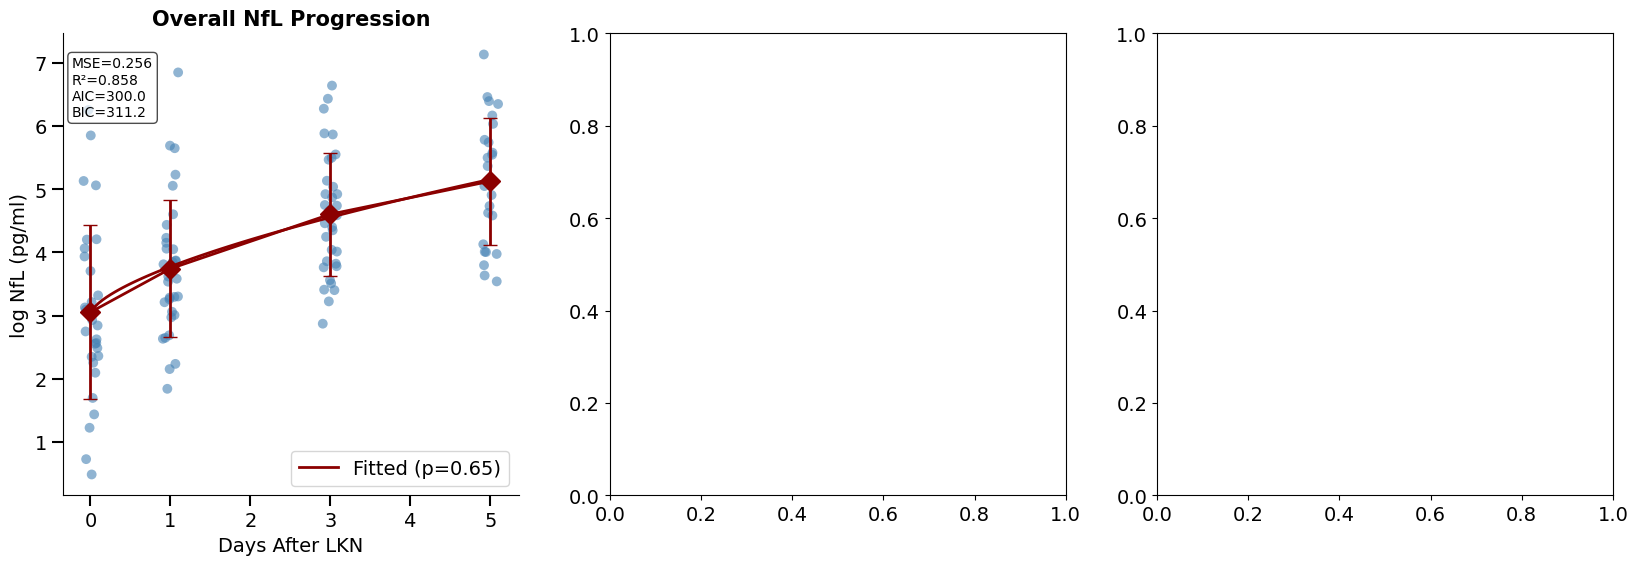

changes from 0 to 1: 22.918698662797244
changes from 1 to 3: 51.32775227743205
changes from 3 to 5: 78.14227270742207
changes from 4 to 5: 43.180473886844425


In [14]:
# additional plotting, overlay the fitted line and actual line
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
x_order = [0, 1, 3, 5]
jitter_strength = 0.1  # adjust (e.g., ±0.1 days)
x_jittered = nfl_plot_data["days_after_lkn"] + np.random.uniform(
    -jitter_strength, jitter_strength, size=len(nfl_plot_data)
)


# === Panel 1: Raw NfL ===
ax = axes[0]
ax.scatter(
    x_jittered,
    nfl_plot_data["log_nfl"],
    alpha=0.6,
    s=50,
    color="steelblue",
    edgecolor="none"
)
stats = get_summary(nfl_plot_data, 'log_nfl')
ax.errorbar(stats['days_after_lkn'], stats['mean'], yerr=stats['std'],
            fmt='D-', color='darkred', linewidth=2, markersize=10, capsize=5)
ax.set_title('Overall NfL Progression', fontsize=15, fontweight='bold')
ax.set_xlabel('Days After LKN')
ax.set_ylabel('log NfL (pg/ml)')

ax.grid(False)
p = best_power['log_nfl']

t_seq = np.linspace(nfl_plot_data["days_after_lkn"].min(), nfl_plot_data["days_after_lkn"].max(), 100)
y_pred_line = (
    goodness[yvar]["Intercept"] +
    goodness[yvar]["Slope"] * (t_seq ** p)
)
ax.plot(t_seq, y_pred_line, color="darkred", linewidth=2, label=f"Fitted (p={p:.2f})")
ax.text(
    0.02, 0.95,
    f"MSE={goodness[yvar]['MSE']:.3f}\nR²={goodness[yvar]['R2']:.3f}\n"
    f"AIC={goodness[yvar]['AIC']:.1f}\nBIC={goodness[yvar]['BIC']:.1f}",
    transform=ax.transAxes, fontsize=10, va="top", ha="left",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)

ax.legend()
ax.grid(False)
ax.tick_params(
    axis='both',
    which='both',
    length=8,      # increase tick length
    width=1.5,     # tick line width
    direction='out'
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
outpath = os.path.join(fig_dir, f"raw_log_nfl_overlay.pdf")
fig.savefig(outpath)
plt.show()

# do calculation, on day 1, the nfl levels is
print(f'changes from 0 to 1: {np.exp(3.027 + 0.747) - np.exp(3.027)}')
print(f'changes from 1 to 3: {np.exp(3.027 + 0.747*3**(0.65)) - np.exp(3.027+0.747*1**(0.65))}')
print(f'changes from 3 to 5: {np.exp(3.027 + 0.747*5**(0.65)) - np.exp(3.027+0.747*3**(0.65))}')
print(f'changes from 4 to 5: {np.exp(3.027 + 0.747*5**(0.65)) - np.exp(3.027+0.747*4**(0.65))}')

## functions for analyzing continous variables

In [16]:
# helper function
def _get_metrics(result, df, yvar, name):
    pred = result.fittedvalues
    resid = df[yvar] - pred
    return {
        "Model": name,
        "AIC": result.aic,
        "BIC": result.bic,
        "logLik": result.llf,
        "MSE": np.mean(resid**2),
        "R2": 1 - np.var(resid, ddof=1)/np.var(df[yvar], ddof=1) if df[yvar].var(ddof=1) > 0 else np.nan,
    }

def estimate_peak_and_sigma(times, values, smooth=0.5):
    """
    Fit a smoothing spline to |values| and compute μ (peak location)
    and σ (half-max width) in continuous time.
    """
    t = np.asarray(times, float)
    v = np.abs(np.asarray(values, float))

    spl = UnivariateSpline(t, v, s=smooth)

    t_dense = np.linspace(t.min(), t.max(), 500)
    v_dense = spl(t_dense)

    # Peak location μ
    peak_idx = np.argmax(v_dense)
    mu = t_dense[peak_idx]
    peak_val = v_dense[peak_idx]

    half_val = 0.5 * peak_val

    above = v_dense >= half_val
    idx_left = np.where(np.diff(above.astype(int)) < 0)[0]
    idx_right = np.where(np.diff(above.astype(int)) > 0)[0]

    if len(idx_left) > 0:
        left_t = t_dense[idx_left[-1]]
    else:
        left_t = t.min()

    if len(idx_right) > 0:
        right_t = t_dense[idx_right[0] + 1]
    else:
        right_t = t.max()

    sigma = max( (right_t - left_t) / 2, 1/2*(t.max()-t.min()))  # safeguard min width

    return float(mu), float(sigma)
    
def _decide_cont_model(corr_df, slope_df, overall, alpha=0.05, peakiness_thr=0.10, stability_thr=0.20):
    """
    Decide: exclude / linear / gaussian for a continuous predictor.
    - any_sig: overall or any timepoint Spearman p < alpha
    - sign flips among strong/sig timepoints -> exclude
    - localized 'peakiness' -> gaussian, else linear
    """
    any_sig = (overall.get("spearman_p", 1.0) < alpha) or (corr_df["spearman_p"].lt(alpha).any())
    if not any_sig:
        return dict(mode="exclude", reason="No significant overall or per-timepoint association.", mu=None, sigma=None, peak_time=None)

    rvals = corr_df["spearman_r"].to_numpy()
    pvals = corr_df["spearman_p"].to_numpy()
    signs = np.sign(rvals)
    flip_idx = np.where(np.diff(signs) != 0)[0]
    for i in flip_idx:
        left_r, right_r = abs(rvals[i]), abs(rvals[i+1])
        left_p, right_p = pvals[i], pvals[i+1]
        if ((left_p < alpha and right_p < alpha) or (left_r > stability_thr and right_r > stability_thr)):
            return dict(mode="exclude", reason="Association flips direction between strong/significant timepoints.", mu=None, sigma=None, peak_time=None)

    merged = pd.merge(corr_df[["time","spearman_r","spearman_p"]],
                      slope_df[["time","beta","se","p"]],
                      on="time", how="inner").dropna()
    if merged.empty or (merged["beta"].abs().sum() == 0):
        return dict(mode="linear", reason="Insufficient slope data; default to linear.", mu=None, sigma=None, peak_time=None)

    times = merged["time"].to_numpy()
    betas = merged["beta"].to_numpy()
    sig_mask = merged["spearman_p"].to_numpy() < alpha
    n_sig = int(sig_mask.sum())

    peakiness = corr_df["spearman_r"].abs().max() - np.median(corr_df["spearman_r"].abs())
    
    spears = corr_df["spearman_r"].to_numpy()
    peak_time, sigma = estimate_peak_and_sigma(times, spears, smooth=0.3)


    if n_sig == 0:
        if overall.get("spearman_p", 1.0) < alpha:
            return dict(mode="linear", reason="Overall significant; per-timepoint underpowered → linear.", mu=None, sigma=None, peak_time=None)
        else:
            return dict(mode="exclude", reason="All tests non-significant; exclude.", mu=None, sigma=None, peak_time=None)

    if peakiness >= peakiness_thr:
        return dict(mode="gaussian", reason=f"Localized effect (peak at day {peak_time:.2f}).", mu=peak_time, sigma=sigma, peak_time=peak_time)
    else:
        return dict(mode="linear", reason="Broad consistent effect across timepoints.", mu=None, sigma=None, peak_time=None)


def compare_continuous_models(nfl_plot_data, yvar, cont_var, best_power_base, fig_dir, tp_list=(0,1,3,5),
                              alpha=0.05, peakiness_thr=0.10, stability_thr=0.20):
    """

    Computes per-timepoint & overall correlations (Pearson/Spearman), OLS slopes,
    decides linear vs Gaussian-modulated effect, fits mixed models with power search,
    returns stats + visuals.

    Returns:
      comp_df        : model comparison metrics
      best_power     : best time exponent for final model
      final_res      : fitted MixedLM results object
      result_row     : dict with effect sizes & p-values (incl. standardized beta)
      corr_df        : per-timepoint correlations (n, r, p)
      slope_df       : per-timepoint OLS slopes (β, SE, p)
    """
    df = nfl_plot_data.copy()
    needed = ["personid", "days_after_lkn", yvar, cont_var]
    df = df[needed].dropna()
    df["days_after_lkn"] = pd.to_numeric(df["days_after_lkn"], errors="coerce")
    df = df.dropna(subset=["days_after_lkn"])
    if df.empty:
        raise ValueError("No data after cleaning for continuous analysis.")

    corr_records = []
    valid_tps = sorted(set(df["days_after_lkn"]) & set(tp_list))
    for tp in valid_tps:
        sub = df[df["days_after_lkn"] == tp][[cont_var, yvar]].dropna()
        if len(sub) >= 6 and sub[cont_var].var(ddof=1) > 0 and sub[yvar].var(ddof=1) > 0:
            rs, ps = spearmanr(sub[cont_var], sub[yvar], nan_policy="omit")
            rp, pp = pearsonr(sub[cont_var], sub[yvar])
            lo_s, hi_s = _fisher_z_ci(rs, len(sub))
            lo_p, hi_p = _fisher_z_ci(rp, len(sub))
            corr_records.append(dict(time=tp, n=len(sub),
                                     spearman_r=rs, spearman_p=ps, spearman_ci=f"[{lo_s:.3f}, {hi_s:.3f}]",
                                     pearson_r=rp, pearson_p=pp, pearson_ci=f"[{lo_p:.3f}, {hi_p:.3f}]"))
    corr_df = pd.DataFrame(corr_records)

    if df[cont_var].var(ddof=1) > 0 and df[yvar].var(ddof=1) > 0:
        rs_all, ps_all = spearmanr(df[cont_var], df[yvar], nan_policy="omit")
        rp_all, pp_all = pearsonr(df[cont_var], df[yvar])
        lo_s, hi_s = _fisher_z_ci(rs_all, len(df))
        lo_p, hi_p = _fisher_z_ci(rp_all, len(df))
    else:
        rs_all = ps_all = rp_all = pp_all = np.nan
        lo_s = hi_s = lo_p = hi_p = np.nan

    overall = dict(spearman_r=rs_all, spearman_p=ps_all,
                   pearson_r=rp_all, pearson_p=pp_all,
                   spearman_ci=f"[{lo_s:.3f}, {hi_s:.3f}]",
                   pearson_ci=f"[{lo_p:.3f}, {hi_p:.3f}]")

    slope_records = []
    for tp in valid_tps:
        sub = df[df["days_after_lkn"] == tp][[cont_var, yvar]].dropna()
        if len(sub) >= 6 and sub[cont_var].var(ddof=1) > 0:
            X = sm.add_constant(sub[cont_var])
            model = sm.OLS(sub[yvar], X).fit()
            slope_records.append(dict(time=tp,
                                      beta=model.params[cont_var],
                                      se=model.bse[cont_var],
                                      p=model.pvalues[cont_var]))
    slope_df = pd.DataFrame(slope_records)

    # decision
    decision = _decide_cont_model(corr_df, slope_df, overall,
                                  alpha=alpha, peakiness_thr=peakiness_thr, stability_thr=stability_thr)
    print(f"Decision: {decision['mode'].upper()} | {decision['reason']}")

    # ---- Base mixed model: y ~ time_pow ----
    base_p = float(best_power_base.get(yvar, 1.0))
    df["time_pow"] = df["days_after_lkn"] ** base_p
    base_model = smf.mixedlm(f"{yvar} ~ time_pow", df, groups=df["personid"], re_formula="1")
    base_res = base_model.fit(method="powell", reml=False, disp=False)

    if decision["mode"] == "exclude":
        best_power = base_p
        df["time_pow"] = df["days_after_lkn"] ** best_power
        final_res = smf.mixedlm(f"{yvar} ~ time_pow", df, groups=df["personid"], re_formula="1").fit(
            method="powell", reml=False, disp=False
        )
        final_mode = "exclude"
    else:
        powers = np.linspace(0.3, 1.8, 31)
        best_power, best_aic, best_params = None, np.inf, None
        best_mode = decision["mode"]
        mu, sigma = decision.get("mu"), decision.get("sigma")

        for p in powers:
            df["time_pow_tmp"] = df["days_after_lkn"] ** p
            if best_mode == "linear":
                df["cont_effect_tmp"] = df[cont_var]
                formula = f"{yvar} ~ time_pow_tmp + cont_effect_tmp"
            else:  # gaussian
                df["cont_effect_tmp"] = df[cont_var] * np.exp(-((df["days_after_lkn"] - mu)**2) / (2 * (sigma**2)))
                formula = f"{yvar} ~ time_pow_tmp + cont_effect_tmp"
            try:
                m = smf.mixedlm(formula, df, groups=df["personid"], re_formula="1").fit(
                    method="powell", reml=False, disp=False
                )
                if m.aic < best_aic:
                    best_aic, best_power, best_params = m.aic, float(p), m.fe_params.copy()
            except Exception:
                continue

        # Refit final with canonical names 'time_pow' and 'cont_effect'
        df["time_pow"] = df["days_after_lkn"] ** (best_power if best_power is not None else base_p)
        if best_mode == "linear":
            df["cont_effect"] = df[cont_var]
            final_formula = f"{yvar} ~ time_pow + cont_effect"
        elif best_mode == "gaussian":
            df["cont_effect"] = df[cont_var] * np.exp(-((df["days_after_lkn"] - mu)**2) / (2 * (sigma**2)))
            final_formula = f"{yvar} ~ time_pow + cont_effect"
        else:
            final_formula = f"{yvar} ~ time_pow"

        final_res = smf.mixedlm(final_formula, df, groups=df["personid"], re_formula="1").fit(
            method="powell", reml=False, disp=False
        )
        final_mode = best_mode
        if best_power is None:
            best_power = base_p  # fallback safeguard

    comp = pd.DataFrame([
        _get_metrics(base_res, df, yvar, f"Base (p={base_p:.3f})"),
        _get_metrics(final_res, df, yvar, f"{final_mode.capitalize()} (p={best_power:.3f})")
    ])

    fe = final_res.fe_params.to_dict()
    beta_cont = fe.get("cont_effect", np.nan)
    sd_x = df[cont_var].std(ddof=1)
    sd_y = df[yvar].std(ddof=1)
    # standardized beta
    std_beta = beta_cont * (sd_x / sd_y) if (np.isfinite(beta_cont) and sd_x > 0 and sd_y > 0) else np.nan
    # p_cont = final_res.pvalues.to_dict().get("cont_effect", np.nan)


    coef_base  = base_res.fe_params.to_dict()
    p_base     = base_res.pvalues.to_dict()
    coef_final = final_res.fe_params.to_dict()
    p_final    = final_res.pvalues.to_dict()
    
    cont_key = "cont_effect" if "cont_effect" in coef_final else None
    
    # Generic summary (works for any continuous predictor)
    coef_summary = {
        "Intercept_base":     coef_base.get("Intercept", np.nan),
        "Intercept_base_p":   p_base.get("Intercept", np.nan),
        "time_pow_base":      coef_base.get("time_pow", np.nan),
        "time_pow_base_p":    p_base.get("time_pow", np.nan),
    
        "Intercept_final":    coef_final.get("Intercept", np.nan),
        "Intercept_final_p":  p_final.get("Intercept", np.nan),
        "time_pow_final":     coef_final.get("time_pow", np.nan),
        "time_pow_final_p":   p_final.get("time_pow", np.nan),
    
        # generic name
        "cont_effect_final":     coef_final.get(cont_key, np.nan) if cont_key else np.nan,
        "cont_effect_final_p":   p_final.get(cont_key, np.nan)    if cont_key else np.nan,
    
        f"{cont_var}_effect_final":   coef_final.get(cont_key, np.nan) if cont_key else np.nan,
        f"{cont_var}_effect_final_p": p_final.get(cont_key, np.nan)    if cont_key else np.nan,
    }
    
    MSE_base  = comp.loc[0, "MSE"]
    MSE_final = comp.loc[1, "MSE"]
    R2_base   = comp.loc[0, "R2"]
    R2_final  = comp.loc[1, "R2"]
    delta_AIC = comp.loc[0, "AIC"] - comp.loc[1, "AIC"]
    delta_BIC = comp.loc[0, "BIC"] - comp.loc[1, "BIC"]
    delta_R2  = R2_final - R2_base
    delta_MSE = MSE_base - MSE_final
    
    result_row = {
        "response": yvar,
        "predictor": cont_var,
        "mode": final_mode,
        "best_power_base": base_p,
        "best_power_final": best_power,
    
        # Overall correlations (parametric and nonparametric)
        "overall_spearman_r": overall["spearman_r"],
        "overall_spearman_p": overall["spearman_p"],
        "overall_spearman_ci": overall["spearman_ci"],
        "overall_pearson_r":  overall["pearson_r"],
        "overall_pearson_p":  overall["pearson_p"],
        "overall_pearson_ci": overall["pearson_ci"],
    
        # Model fit metrics (base vs final)
        "AIC_base":  base_res.aic,
        "AIC_final": final_res.aic,
        "BIC_base":  base_res.bic,
        "BIC_final": final_res.bic,
        "logLik_base":  base_res.llf,
        "logLik_final": final_res.llf,
        "MSE_base":  MSE_base,
        "MSE_final": MSE_final,
        "R2_base":   R2_base,
        "R2_final":  R2_final,
    
        # Deltas
        "delta_AIC": delta_AIC,
        "delta_BIC": delta_BIC,
        "delta_R2":  delta_R2,
        "delta_MSE": delta_MSE,
    
        # Continuous effect strength
        "beta_cont":        coef_final.get(cont_key, np.nan) if cont_key else np.nan,
        "beta_cont_p":      p_final.get(cont_key, np.nan)    if cont_key else np.nan,
        "std_beta_cont":    std_beta,
    }
    if final_mode == "gaussian":
        result_row["gauss_mu"] = float(mu)
        result_row["gauss_sigma"] = float(sigma)
    else:
        result_row["gauss_mu"] = np.nan
        result_row["gauss_sigma"] = np.nan
    
    result_row.update(coef_summary)

    corr_out = corr_df.merge(
        slope_df.rename(columns={"beta":"ols_beta","se":"ols_se","p":"ols_p"}),
        on="time", how="outer"
    ) if not corr_df.empty or not slope_df.empty else pd.DataFrame(columns=["time","n","spearman_r","spearman_p","spearman_ci","pearson_r","pearson_p","pearson_ci","ols_beta","ols_se","ols_p"])
    
    corr_out["response"]  = yvar
    corr_out["predictor"] = cont_var
    
    
    corr_overall_row = {
        "time": "overall",
        "n": len(df),
        "spearman_r": overall["spearman_r"],
        "spearman_p": overall["spearman_p"],
        "spearman_ci": overall["spearman_ci"],
        "pearson_r": overall["pearson_r"],
        "pearson_p": overall["pearson_p"],
        "pearson_ci": overall["pearson_ci"],
        "ols_beta": np.nan, "ols_se": np.nan, "ols_p": np.nan,
        "response": yvar, "predictor": cont_var
    }
    corr_out = pd.concat([corr_out, pd.DataFrame([corr_overall_row])], ignore_index=True)

    # printing
    print("\n" + "="*80)
    print(f"Correlation summary: {yvar} vs {cont_var}")
    print("="*80)

    #  numeric rounding
    def _fmt(x):
        return "NA" if pd.isna(x) else f"{x:.3f}"

    # Sort with overall at the end
    corr_print = corr_out.copy()
    corr_print["time_sort"] = corr_print["time"].apply(
        lambda x: np.inf if x == "overall" else float(x)
    )
    corr_print = corr_print.sort_values("time_sort")

    for _, row in corr_print.iterrows():
        time_label = "Overall (all days)" if row["time"] == "overall" else f"Day {row['time']}"

        print(f"\n[{time_label}]")
        print(
            f"  n = {int(row['n']) if pd.notna(row['n']) else 'NA'} | "
            f"Spearman r = {_fmt(row['spearman_r'])} "
            f"(p = {_fmt(row['spearman_p'])}, CI {row['spearman_ci']}) | "
            f"Pearson r = {_fmt(row['pearson_r'])} "
            f"(p = {_fmt(row['pearson_p'])}, CI {row['pearson_ci']})"
        )


    print("\n=== Mixed-Effects Model Summaries ===")
    print("\n--- Base Model ---")
    print(base_res.summary())
    print(f"\n--- Final Model ({final_mode.capitalize()}) ---")
    print(final_res.summary())

    return comp, best_power, final_res, result_row, corr_out

## Summarize - Figure 3

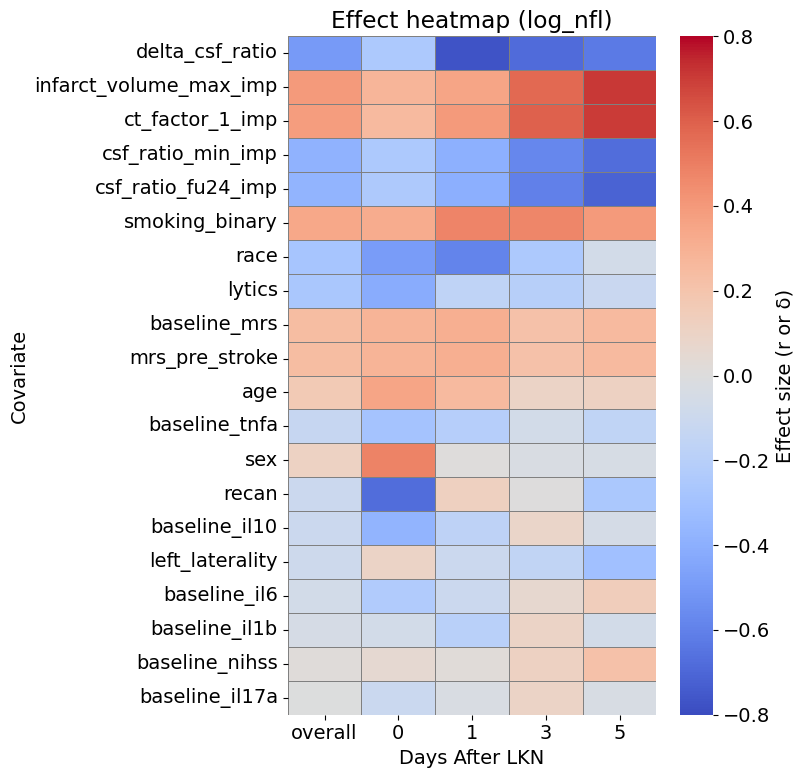

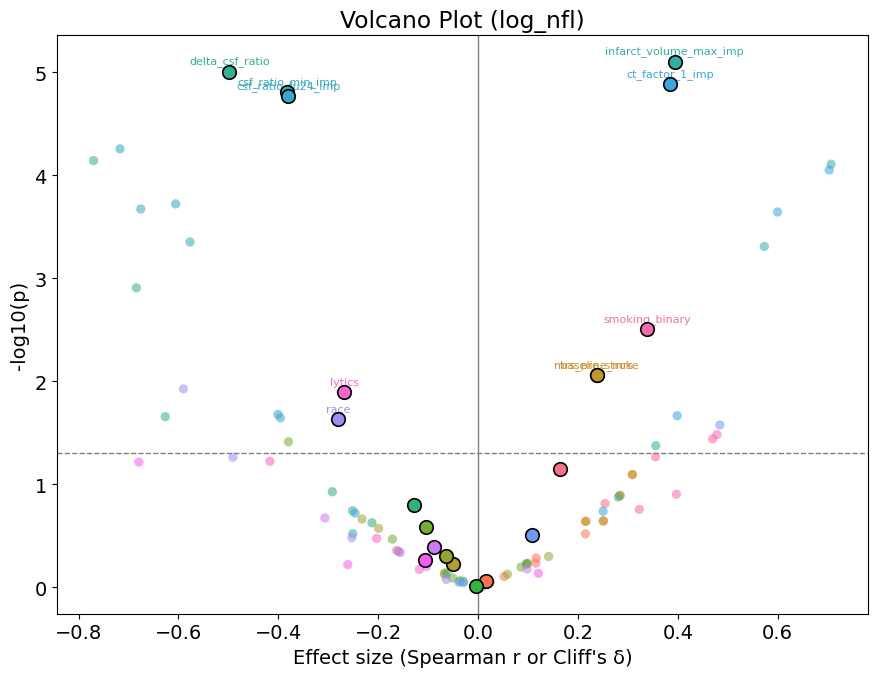

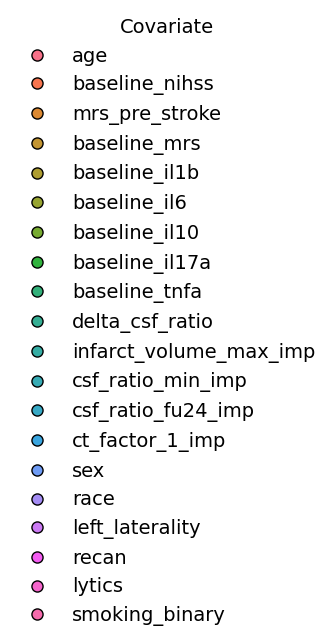

In [20]:
# read both categorical and continuous variable

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
cont_models = pd.read_csv("nfl_continuous_models.csv")
cont_corr_df_all = pd.read_csv("nfl_continuous_correlations.csv")

imputed_cont_models = pd.read_csv("imputed_nfl_continuous_models.csv")
imputed_cont_corr_df_all = pd.read_csv("imputed_nfl_continuous_correlations.csv")
cont_models["source"] = "original"
imputed_cont_models["source"] = "imputed"

cont_corr_df_all["source"] = "original"
imputed_cont_corr_df_all["source"] = "imputed"
all_cols_models = list(set(cont_models.columns) | set(imputed_cont_models.columns))
cont_models = cont_models.reindex(columns=all_cols_models)
imputed_cont_models = imputed_cont_models.reindex(columns=all_cols_models)

#  correlation tables
all_cols_corr = list(set(cont_corr_df_all.columns) | set(imputed_cont_corr_df_all.columns))
cont_corr_df_all = cont_corr_df_all.reindex(columns=all_cols_corr)
imputed_cont_corr_df_all = imputed_cont_corr_df_all.reindex(columns=all_cols_corr)

# ---  merge
merged_cont_models = pd.concat([cont_models, imputed_cont_models], ignore_index=True)
merged_cont_corr = pd.concat([cont_corr_df_all, imputed_cont_corr_df_all], ignore_index=True)

cont_models = merged_cont_models
cont_corr_df_all = merged_cont_corr

categorical_models = pd.read_csv("nfl_categorical_models.csv")
categorical_corr_df_all = pd.read_csv("nfl_categorical_effects.csv")

#   fields 
cont_corr_df_all = cont_corr_df_all[
    ["predictor", "spearman_r", "spearman_p", "response", "time"]
].rename(columns={
    "predictor": "variable",
    "spearman_r": "effect",
    "spearman_p": "p",
})
cont_corr_df_all["type"] = "continuous"

categorical_corr_df_all = categorical_corr_df_all[
    ["categorical_var", "cliff_delta", "mann_p", "response", "time"]
].rename(columns={
    "categorical_var": "variable",
    "cliff_delta": "effect",
    "mann_p": "p",
})
categorical_corr_df_all["type"] = "categorical"

corr_df_all = pd.concat([cont_corr_df_all, categorical_corr_df_all], ignore_index=True)


for response_var in ["log_nfl"]:
    corr_df_current = corr_df_all.query("response == @response_var").copy()

    corr_df_current = corr_df_current[corr_df_current["variable"].notna()]

    corr_pivot = corr_df_current.pivot(index="variable", columns="time", values="effect")

    times = [t for t in corr_pivot.columns if t != "overall"]
    try:
        times_sorted = sorted(times, key=lambda x: float(x))
    except Exception:
        times_sorted = times
    time_cols = ["overall"] + times_sorted if "overall" in corr_pivot.columns else times_sorted
    corr_pivot = corr_pivot[time_cols]

    if "overall" in corr_pivot.columns:
        ranked_vars = corr_pivot["overall"].abs().sort_values(ascending=False).index
    else:
        ranked_vars = corr_pivot.abs().mean(axis=1).sort_values(ascending=False).index
    corr_pivot = corr_pivot.loc[ranked_vars]

    plt.figure(figsize=(8, max(5, 0.4 * len(ranked_vars))))
    sns.heatmap(
        corr_pivot,
        cmap="coolwarm", vmin=-0.8, vmax=0.8, center=0,
        cbar_kws={"label": "Effect size (r or δ)"},
        linewidths=0.4, linecolor="gray"
    )
    plt.title(f"Effect heatmap ({response_var})")
    plt.xlabel("Days After LKN")
    plt.ylabel("Covariate")
    plt.tight_layout()
    plt.show()

    #  Volcano plot:
    corr_df_current["neglog10_p"] = -np.log10(corr_df_current["p"].clip(lower=1e-10))
    corr_df_current["abs_effect"] = corr_df_current["effect"].abs()

    df_overall = corr_df_current[corr_df_current["time"] == "overall"].copy()
    df_timepts = corr_df_current[corr_df_current["time"] != "overall"].copy()

    variables = df_overall["variable"].unique()
    palette = dict(zip(variables, sns.color_palette("husl", len(variables))))

    plt.figure(figsize=(9, 7))

    # plot all timepoints (colored by variable)
    for var in variables:
        sub = df_timepts[df_timepts["variable"] == var]
        plt.scatter(
            sub["effect"], sub["neglog10_p"],
            s=45,
            c=[palette[var]],
            alpha=0.55,
            edgecolor="none"
        )

    # overlay overall (larger with black outline)
    for _, row in df_overall.iterrows():
        plt.scatter(
            row["effect"], row["neglog10_p"],
            s=95,
            c=[palette[row["variable"]]],
            edgecolor="black", linewidth=1.2, zorder=5
        )

    # reference lines
    plt.axhline(-np.log10(0.05), color="gray", ls="--", lw=1)
    plt.axvline(0, color="gray", lw=1)
    plt.xlabel("Effect size (Spearman r or Cliff's δ)")
    plt.ylabel("-log10(p)")
    plt.title(f"Volcano Plot ({response_var})")

    # annotate significant or strong effects (overall)
    sig_mask = (df_overall["p"] < 0.05) | (df_overall["abs_effect"] > 0.4)
    for _, row in df_overall[sig_mask].iterrows():
        plt.text(
            row["effect"], row["neglog10_p"] + 0.05,
            row["variable"],
            color=palette[row["variable"]],
            ha="center", va="bottom", fontsize=8
        )

    # legend
    handles = [
        plt.Line2D(
            [0], [0],
            marker="o", color="w",
            markerfacecolor=palette[v], markeredgecolor="black",
            markersize=8, label=v
        )
        for v in variables
    ]

    plt.tight_layout()
 
    plt.show()


    fig_legend = plt.figure(figsize=(4, 6))
    ax = fig_legend.add_subplot(111)
    ax.axis("off")
    
    ax.legend(
        handles=handles,
        title="Covariate",
        frameon=False,
        loc="center"
    )
    
    


## imaging imputation
“Suitability for factor analysis was confirmed using Bartlett’s test of sphericity and the KMO measure.”
<!--  -->

csf_ratio_min        -0.992132
csf_ratio_fu24       -0.990698
infarct_volume_max    0.958892
dtype: float64

=== Missingness Before Imputation ===
                    pct_missing_before
ct_factor_1                   0.428571
infarct_volume_max            0.342857
csf_ratio_fu24                0.171429
csf_ratio_min                 0.028571

=== Missingness After Imputation ===
                        pct_missing_after
infarct_volume_max_imp                0.0
csf_ratio_min_imp                     0.0
csf_ratio_fu24_imp                    0.0
ct_factor_1_imp                       0.0

=== CT Factor 1 Loadings (sorted) ===
csf_ratio_min        -0.992132
csf_ratio_fu24       -0.990698
infarct_volume_max    0.958892
dtype: float64

CT factor is primarily driven by **csf_ratio_min**; higher factor = better CT profile.


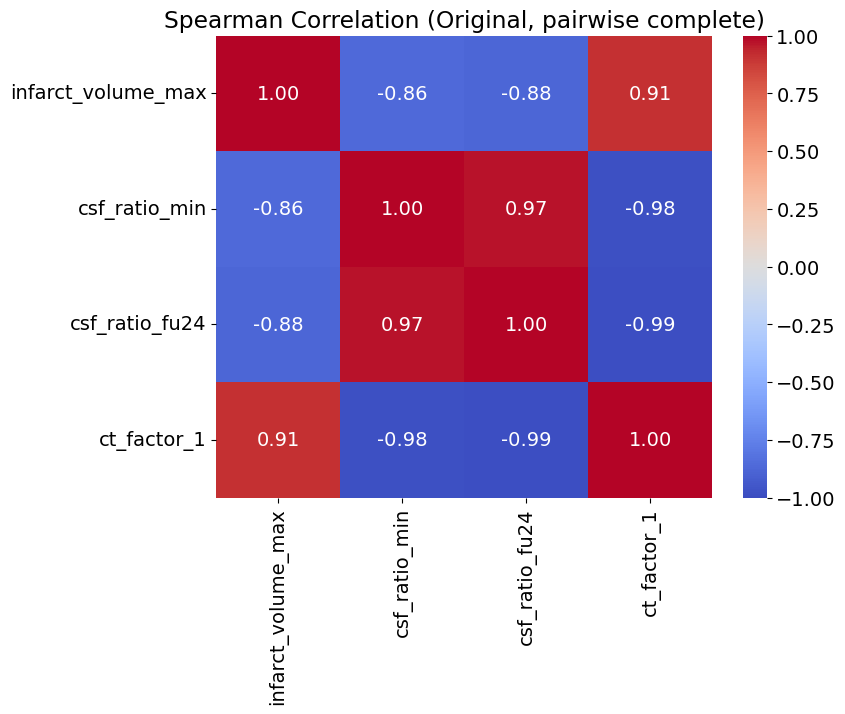

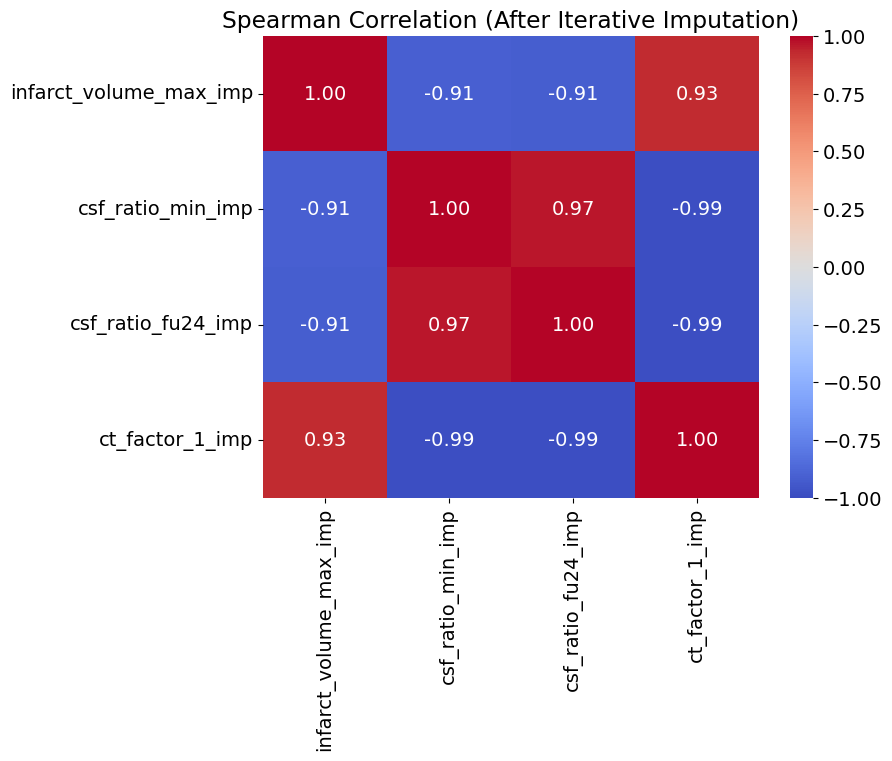


=== CT Factor Relationship Table ===
                              variable   loading  spearman_with_factor  \
infarct_volume_max  infarct_volume_max  0.958892              0.911278   
csf_ratio_fu24          csf_ratio_fu24 -0.990698             -0.987970   
csf_ratio_min            csf_ratio_min -0.992132             -0.981955   

                    n_non_missing  
infarct_volume_max             23  
csf_ratio_fu24                 29  
csf_ratio_min                  34  
Spearman Δ (Frobenius norm): 0.086
Pearson  Δ (Frobenius norm): 0.063
Spearman mean abs diff: 0.013
Pearson  mean abs diff: 0.010
Mantel test (Spearman matrices): r=1.000, p=0.042
=== Number of UNIQUE non-missing values per patient, per CT factor ===
    personid  infarct_volume_max  csf_ratio_min  csf_ratio_fu24
0          3                   0              1               1
1          4                   1              1               1
2          5                   0              1               0
3          6  

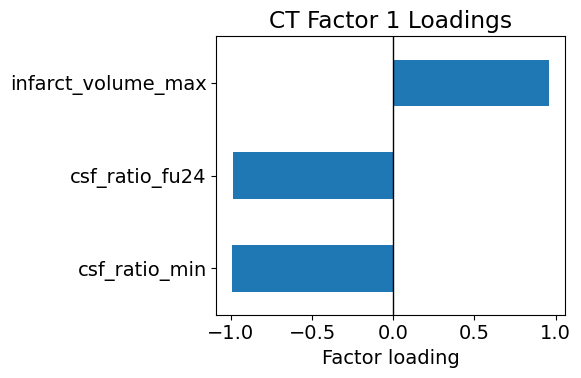

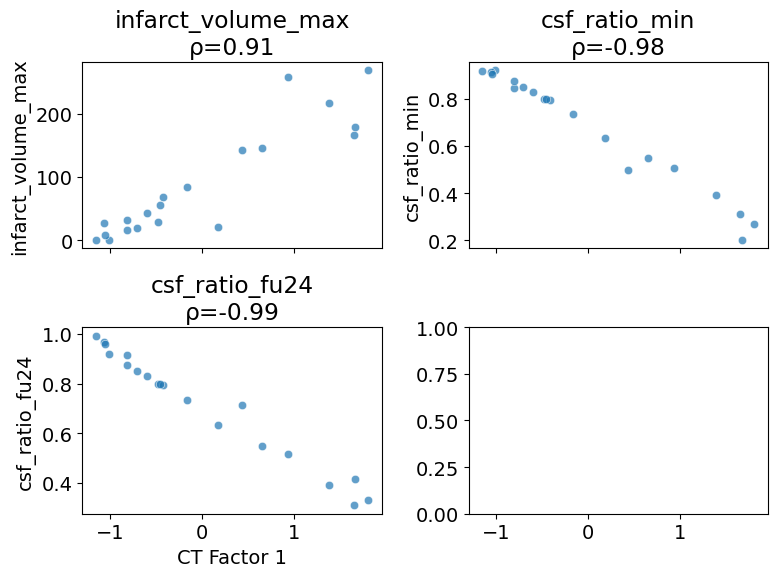

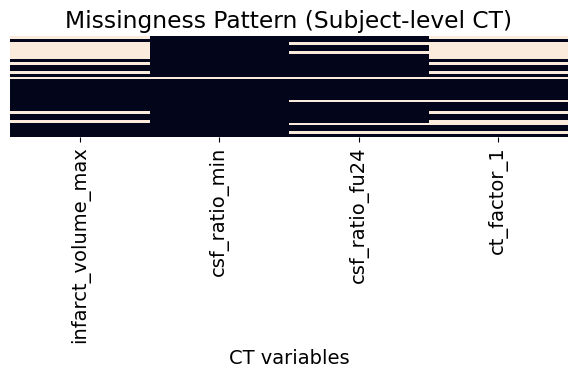

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


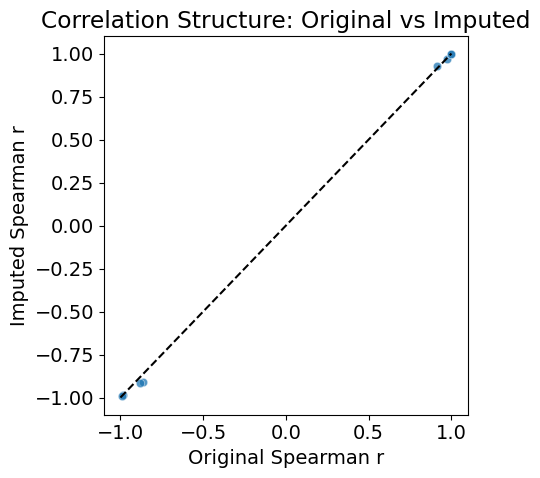

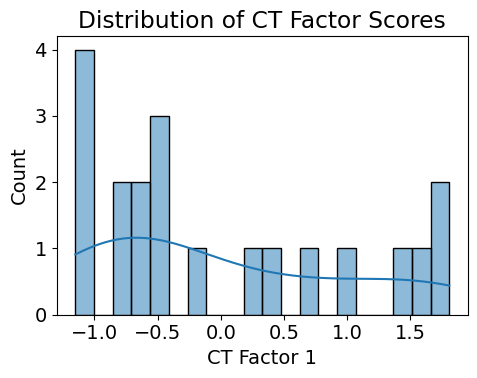

In [58]:
# we see delta_csf correlate with transient nfl data, therefore we should not do factor analysis

# we will be focusing on log_nfl, we know csf
# let's see if we need imputation for ct imagings
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.distance import mantel
def pairwise_corr_table(df, cols, method=("pearson","spearman"), fdr=True):
    """
    Returns a long-form table of pairwise correlations with p-values.
    Pairwise complete observations for each variable pair.
    """
    records = []
    for a, b in combinations(cols, 2):
        x = df[a]
        y = df[b]
        ok = x.notna() & y.notna()
        xa, yb = x[ok].astype(float), y[ok].astype(float)
        n = len(xa)
        if n < 3:
            rec = {"var1": a, "var2": b, "n": n,
                   "r_pearson": np.nan, "p_pearson": np.nan,
                   "r_spearman": np.nan, "p_spearman": np.nan}
        else:
            r_p, p_p = pearsonr(xa, yb)
            r_s, p_s = spearmanr(xa, yb)
            rec = {"var1": a, "var2": b, "n": n,
                   "r_pearson": r_p, "p_pearson": p_p,
                   "r_spearman": r_s, "p_spearman": p_s}
        records.append(rec)
    out = pd.DataFrame(records)

    if fdr:
        # Benjamini–Hochberg across all reported tests (pearson + spearman)
        def bh(p):
            p = p.copy()
            mask = p.notna()
            m = mask.sum()
            if m == 0: 
                return p
            ranks = p[mask].rank(method="first")
            adj = (p[mask] * m / ranks).clip(upper=1.0)
            # enforce monotonicity
            adj_sorted = adj.sort_values(ascending=False).cummin().sort_index()
            p.loc[mask] = adj_sorted
            return p

        out["q_pearson"] = bh(out["p_pearson"])
        out["q_spearman"] = bh(out["p_spearman"])
    return out.sort_values(["p_spearman","p_pearson"], na_position="last")
ct_imaging_variables = ['infarct_volume_max', 'csf_ratio_min',  'csf_ratio_fu24']
# 'csf_baseline', 'csf_ratio_baseline', 'csf_fu24', we only care about ratio for now

nfl_df = pd.read_csv('nihss_nfl_cyto_mrs_wbc_mrs_ct.csv', 
                     index_col=0)

ct_data = nfl_df.copy()

# ensure correct sort order (earliest first if you care)
ct_data = ct_data.sort_values(["personid", "timepoint_nihss"], na_position="last")

# collapse to subject-level
ct_subject_level = (
    ct_data.groupby("personid")[ct_imaging_variables]
    .apply(lambda x: x.ffill().bfill().iloc[0])  # forward/back fill then take first
    .reset_index()
)
ct_subject_level

# # Subset and standardize (fit on available rows only)
X_ct = ct_subject_level[ct_imaging_variables].astype(float)
scaler = StandardScaler()
X_ct_z = pd.DataFrame(scaler.fit_transform(X_ct), 
                      columns=ct_imaging_variables, index=X_ct.index)

# Factor analysis with 1 factor
fa = FactorAnalysis(n_components=1, random_state=0)
# FactorAnalysis cannot handle NaNs: drop rows with any NaN to fit
fit_idx = X_ct_z.dropna().index
fa.fit(X_ct_z.loc[fit_idx, :])

# # Compute factor scores where possible (rows without NaNs in CT block)
scores = np.full((len(X_ct_z), 1), np.nan)
ok_rows = X_ct_z.dropna().index
scores[X_ct_z.index.get_indexer(ok_rows)] = fa.transform(X_ct_z.loc[ok_rows, :])

X_ct["ct_factor_1"] = scores.ravel()
loadings = pd.Series(fa.components_[0], index=ct_imaging_variables).sort_values()

analysis_vars = ct_imaging_variables + ["ct_factor_1"]  # extend as needed
Z = X_ct[analysis_vars].astype(float)

imputer = IterativeImputer(
    random_state=0,
    sample_posterior=False,   # set True for Bayesian draws
    max_iter=20,
    tol=1e-3,
)
Z_imp = pd.DataFrame(imputer.fit_transform(Z), columns=analysis_vars, index=Z.index)

# Keep an imputed copy alongside originals
for c in analysis_vars:
    X_ct[f"{c}_imp"] = Z_imp[c]

# Choose variables to correlate (e.g., log_nfl with each CT and ct_factor_1)
corr_vars_original = ct_imaging_variables + ["ct_factor_1"]
corr_vars_imputed  = [f"{c}_imp" for c in corr_vars_original]

tab_orig = pairwise_corr_table(X_ct, corr_vars_original)
tab_imp  = pairwise_corr_table(X_ct, corr_vars_imputed)

# If you only care about correlations with log_nfl:
def filter_against(target, table):
    return table.query("(var1 == @target) | (var2 == @target)").copy()

tab_orig_vs_nfl = filter_against("log_nfl", tab_orig)
tab_imp_vs_nfl  = filter_against("log_nfl_imp", tab_imp)

# Optional sign flip so factor correlates positively with infarct_volume_max
if loadings.abs().idxmax() == "infarct_volume_max" and loadings["infarct_volume_max"] < 0:
    X_ct["ct_factor_1"] *= -1
    loadings *= -1
print(loadings)

missing_before = X_ct[analysis_vars].isna().mean().sort_values(ascending=False)
missing_after  = X_ct[[f"{c}_imp" for c in analysis_vars]].isna().mean()

print("\n=== Missingness Before Imputation ===")
print(missing_before.to_frame("pct_missing_before"))

print("\n=== Missingness After Imputation ===")
print(missing_after.to_frame("pct_missing_after"))

print("\n=== CT Factor 1 Loadings (sorted) ===")
print(loadings)

# A short interpretation heuristic:
if loadings.abs().max() > 0:
    top = loadings.abs().idxmax()
    direction = "worse" if loadings[top] > 0 else "better"
    print(f"\nCT factor is primarily driven by **{top}**; higher factor = {direction} CT profile.")



# Original
plt.figure(figsize=(8,6))
corr_orig = X_ct[corr_vars_original].corr(method='spearman')
sns.heatmap(corr_orig, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Spearman Correlation (Original, pairwise complete)")

plt.show()

# Imputed
plt.figure(figsize=(8,6))
corr_imp = X_ct[corr_vars_imputed].corr(method='spearman')
sns.heatmap(corr_imp, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Spearman Correlation (After Iterative Imputation)")

plt.show()

summary = pd.DataFrame({
    "variable": ct_imaging_variables,
    "loading": loadings.loc[ct_imaging_variables],
    "spearman_with_factor": [
        spearmanr(X_ct[var], X_ct["ct_factor_1"], nan_policy="omit")[0] 
        for var in ct_imaging_variables
    ],
    "n_non_missing": [X_ct[var].notna().sum() for var in ct_imaging_variables]
})
print("\n=== CT Factor Relationship Table ===")
print(summary.sort_values("loading", ascending=False))

corr_orig_s = X_ct[corr_vars_original].corr(method="spearman")
corr_imp_s  = X_ct[corr_vars_imputed].corr(method="spearman")

corr_orig_p = X_ct[corr_vars_original].corr(method="pearson")
corr_imp_p  = X_ct[corr_vars_imputed].corr(method="pearson")

diff_s = corr_imp_s.values - corr_orig_s.values
diff_p = corr_imp_p.values - corr_orig_p.values
fro_s = np.linalg.norm(diff_s, 'fro')
fro_p = np.linalg.norm(diff_p, 'fro')

print(f"Spearman Δ (Frobenius norm): {fro_s:.3f}")
print(f"Pearson  Δ (Frobenius norm): {fro_p:.3f}")
mad_s = np.abs(diff_s).mean().mean()
mad_p = np.abs(diff_p).mean().mean()


print(f"Spearman mean abs diff: {mad_s:.3f}")
print(f"Pearson  mean abs diff: {mad_p:.3f}")
from scipy.spatial.distance import squareform

# Convert to distance (1 - correlation)
d1 = squareform(1 - corr_orig_s.values)
d2 = squareform(1 - corr_imp_s.values)

mantel_r, mantel_p, _ = mantel(d1, d2, method="pearson", permutations=999)
print(f"Mantel test (Spearman matrices): r={mantel_r:.3f}, p={mantel_p:.3f}")

## merge it back to 
ct_subject_imputed = pd.DataFrame({
    "personid": ct_subject_level["personid"].values
})

for c in analysis_vars:
    ct_subject_imputed[f"{c}_imp"] = X_ct[f"{c}_imp"].values
# ct_subject_imputed["ct_factor_1"] = X_ct["ct_factor_1_imp"]
nfl_df_merged = nfl_df.merge(ct_subject_imputed, on="personid", how="left")
# uncomment for not to output again
# print("\nCheck CT columns after merge (should be 0 missing):")
# print(nfl_df_merged[["ct_factor_1_imp",'infarct_volume_max_imp', 'csf_ratio_min_imp',  'csf_ratio_fu24_imp']].isna().sum())
# out_path = "/Users/ganshengtan/Library/CloudStorage/Box-Box/Washu/projects/taVNS_cytokine/stroke-taVNS/nfl_study/organized_data/nihss_nfl_cyto_mrs_wbc_mrs_imputedct.csv"
# nfl_df_merged.to_csv(out_path)
# print(f"\nSaved merged dataset with imputed CT values:\n{out_path}")


factor_unique_counts_per_patient = (
    ct_data
    .groupby("personid")[ct_imaging_variables]
    .apply(lambda df: df.apply(lambda x: x.dropna().nunique()))
    .reset_index()
)

print("=== Number of UNIQUE non-missing values per patient, per CT factor ===")
print(factor_unique_counts_per_patient)
print("\n=== Distribution of unique values per patient (by factor) ===")
for var in ct_imaging_variables:
    print(f"\n{var}")
    print(factor_unique_counts_per_patient[var].value_counts().sort_index())

# additional validation
plt.figure(figsize=(6,4))
loadings.sort_values().plot(kind="barh")
plt.axvline(0, color="k", linewidth=1)
plt.xlabel("Factor loading")
plt.title("CT Factor 1 Loadings")
plt.tight_layout()

plt.show()
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)

for ax, var in zip(axes.ravel(), ct_imaging_variables):
    sns.scatterplot(
        x=X_ct["ct_factor_1"],
        y=X_ct[var],
        ax=ax,
        alpha=0.7
    )
    r, p = spearmanr(X_ct[var], X_ct["ct_factor_1"], nan_policy="omit")
    ax.set_title(f"{var}\nρ={r:.2f}")
    ax.set_xlabel("CT Factor 1")

plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
sns.heatmap(
    X_ct[analysis_vars].isna(),
    cbar=False,
    yticklabels=False
)
plt.xlabel("CT variables")
plt.title("Missingness Pattern (Subject-level CT)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
sns.scatterplot(
    x=corr_orig_s.values.flatten(),
    y=corr_imp_s.values.flatten(),
    alpha=0.5
)
plt.plot([-1,1], [-1,1], 'k--')
plt.xlabel("Original Spearman r")
plt.ylabel("Imputed Spearman r")
plt.title("Correlation Structure: Original vs Imputed")
plt.tight_layout()

plt.show()


plt.figure(figsize=(5,4))
sns.histplot(X_ct["ct_factor_1"].dropna(), bins=20, kde=True)
plt.xlabel("CT Factor 1")
plt.title("Distribution of CT Factor Scores")
plt.tight_layout()

plt.show()